<a href="https://colab.research.google.com/github/xyuech/Optimization-Algorithms/blob/main/LBFGS_vs_TR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/UMich/IOE 691')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from numpy.linalg import norm
from scipy.optimize import line_search
import matplotlib.pyplot as plt


The goal of this question is to investigate the behavior of L-BFGS (with a Armijo-Wolfe line search) and the Trust-Region Newton CG method (Algorithms 7.5 and 7.2 in the “Numerical Optimization” textbook). Pseudo-code for these methods will be provided in the lecture slides.
The investigation is open-ended. We have provided a list of text problems that you can use to test the methods (IOE691_W24_Project_Problems.pdf). Note, you are not required to test on all problems, but please make sure to investigate a sufficient number (and be able to justify the number). You answer/report should include the following:

* Summarize the algorithms.
* Summarize the test problems selected.
* Summarize and justify your evaluation approach.
* Comment on the overall performance of the methods.
* Comment on the sensitivity of the methods to the parameters.
* Discuss the advantages and limitations of the methods.
* Do you have a clear winner?

Please note that you could and should go beyond the above. Your solution should include text as well as figures, tables, etc to support your findings. You are not required to submit any code. And, you may use any programming language you want.

We understand that this problem is somewhat vague. This is by design. We want you to be creative and think outside the box in your investigation. Please let us know if you have any questions.


# L-BFGS with Armijo-Wolfe Line Search

Input:
- $x_0$: Initial point
- $m$: Memory size for L-BFGS
- $\epsilon$: Convergence tolerance
- $\alpha_0$: Initial step size
- $\rho$: Step size reduction factor
- $c_1$, $c_2$: Armijo-Wolfe line search parameters

Initialize:
- $H_0 = I$ (Identity matrix)
- $k = 0$

While $\|\nabla f(x_k)\| > \epsilon$:
1. Compute search direction: $p_k = -H_k \nabla f(x_k)$
2. Find step size $\alpha_k$ satisfying Armijo-Wolfe conditions:
    - $f(x_k + \alpha_k p_k) \leq f(x_k) + c_1 \alpha_k \nabla f(x_k)^T p_k$
    - $|\nabla f(x_k + \alpha_k p_k)^T p_k| \leq c_2 |\nabla f(x_k)^T p_k|$
3. Update solution: $x_{k+1} = x_k + \alpha_k p_k$
4. Compute $s_k = x_{k+1} - x_k$ and $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$
5. Update L-BFGS memory:
    - Store $s_k$ and $y_k$ in memory
    - If memory size exceeds $m$, discard the oldest pairs
6. Update inverse Hessian approximation $H_{k+1}$ using L-BFGS formula
7. $k = k + 1$

Return $x_k$

## L-BFGS Update Formula
The L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) formula is an update formula for approximating the inverse Hessian matrix in quasi-Newton optimization methods. It is a memory-efficient variant of the BFGS method that uses a limited amount of memory to store the past gradients and solution differences.

The L-BFGS formula updates the inverse Hessian approximation $H_k$ at each iteration $k$ using the following steps:

1. Compute the solution difference: $s_k = x_{k+1} - x_k$
2. Compute the gradient difference: $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$
3. Store $s_k$ and $y_k$ in the L-BFGS memory, discarding the oldest pairs if the memory size exceeds a specified limit $m$.
4. Initialize the inverse Hessian approximation $H_k$ as the identity matrix.
5. For each pair $(s_i, y_i)$ in the L-BFGS memory (from the most recent to the oldest):
   - Compute the scalar $\rho_i = \frac{1}{y_i^T s_i}$
   - Update $H_k$ using the following formula:
     $H_k = (I - \rho_i s_i y_i^T) H_k (I - \rho_i y_i s_i^T) + \rho_i s_i s_i^T$

The L-BFGS formula recursively updates the inverse Hessian approximation $H_k$ using the stored pairs of solution differences $s_i$ and gradient differences $y_i$. The scalar $\rho_i$ is computed as the inverse of the dot product between $y_i$ and $s_i$.

The update formula consists of two parts:
- $(I - \rho_i s_i y_i^T) H_k (I - \rho_i y_i s_i^T)$: This part performs a rank-2 update to $H_k$ using the outer products of $s_i$ and $y_i$.
- $\rho_i s_i s_i^T$: This part adds a rank-1 update to $H_k$ using the outer product of $s_i$ with itself.

By repeatedly applying this update formula for each pair of $(s_i, y_i)$ in the L-BFGS memory, the inverse Hessian approximation $H_k$ is constructed efficiently without storing the full Hessian matrix.

The L-BFGS formula allows for efficient computation of the search direction $$p_k = -H_k \nabla f(x_k)$$ in each iteration of the optimization algorithm. It provides a good approximation of the inverse Hessian matrix while using limited memory, making it suitable for large-scale optimization problems.

The choice of the memory size $m$ in L-BFGS is a trade-off between the accuracy of the inverse Hessian approximation and the computational cost. Typically, values of $m$ between 5 and 20 are commonly used in practice.


# Trust-Region Newton CG Method

Input:
- $x_0$: Initial point
- $\Delta_0$: Initial trust-region radius
- $\epsilon$: Convergence tolerance
- $\eta_1$, $\eta_2$: Trust-region update parameters
- $\gamma_1$, $\gamma_2$: Trust-region scaling factors

Initialize:
- $k = 0$

While $\|\nabla f(x_k)\| > \epsilon$:
1. Solve the trust-region subproblem approximately using CG method:
    $\min_{p} m_k(p) = f(x_k) + \nabla f(x_k)^T p + \frac{1}{2} p^T \nabla^2 f(x_k) p$
    subject to $\|p\| \leq \Delta_k$
2. Compute the ratio: $\rho_k = \frac{f(x_k) - f(x_k + p_k)}{m_k(0) - m_k(p_k)}$
3. Update trust-region radius:
    - If $\rho_k < \eta_1$, set $\Delta_{k+1} = \gamma_1 \Delta_k$
    - Else if $\rho_k > \eta_2$ and $\|p_k\| = \Delta_k$, set $\Delta_{k+1} = \min(\gamma_2 \Delta_k, \Delta_{\max})$
    - Else, set $\Delta_{k+1} = \Delta_k$
4. Update solution:
    - If $\rho_k > \eta_1$, set $x_{k+1} = x_k + p_k$
    - Else, set $x_{k+1} = x_k$
5. $k = k + 1$

Return $x_k$

# Question 1
$f(x)=\frac{1}{2} x^T Q x+q^T x$ where $q \in R^n$ and $Q \in R^{n×n}$. A randomly generated convex quadratic function.

Dimension n = 10;

Condition number κ = 10.

Starting Point: rng(0); x 0=20*rand(10,1)-10.

In [ ]:
import project_problems
import LBFGS
import TrustRegionNewtonCG

In [ ]:
func1 = project_problems.quad_10_10_func
grad1 = project_problems.quad_10_10_grad
hess1 = project_problems.quad_10_10_Hess

In [ ]:
rng = np.random.default_rng(0)
n = 10
x0 = 20 * rng.random((n, 1)) - 10

In [ ]:
lbfgs = LBFGS.LBFGS(func1, grad1)
x_list, g_list, s_list, y_list, k = lbfgs.minimize(x0)
print("Number of iteration: ", k)

Number of iteration:  28


In [ ]:
trnewtoncg = TrustRegionNewtonCG.TrustRegionNewton(func1, grad1, hess1, eta = 0.25)
x_list, f_list, g_list, m_list, p_list, j_list, k = trnewtoncg.minimize(x0, max_radius=4)

print("Number of iteration: ", k)

Number of iteration:  12


/content/drive/MyDrive/Colab Notebooks/UMich/IOE 691/TrustRegionNewtonCG.py:162: RuntimeWarning: invalid value encountered in divide
  rho = (fx - fx_new) / (m0 - mp)


In the context of the given code, `np.logspace(-np.log10(kappa), 0, n)` generates a sequence of n numbers logarithmically spaced between $kappa^{-1}$ and $1$. This is used to generate the eigenvalues of the matrix Q in the quadratic function. By logarithmically spacing the eigenvalues, we can control the condition number kappa of the matrix, which is the ratio of the largest eigenvalue to the smallest eigenvalue.

For example, if `n = 5` and `kappa = 100`, then `np.logspace(-np.log10(kappa), 0, n)` would generate the following array of eigenvalues:
`array([0.01, 0.1 , 1.  ])`

This means that the matrix Q will have eigenvalues ranging from 0.01 to 1, with a condition number of approximately 100.

# Question 2

In [ ]:
func2 = project_problems.quad_10_1000_func
grad2 = project_problems.quad_10_1000_grad
hess2 = project_problems.quad_10_1000_Hess

In [ ]:
trnewtoncg = TrustRegionNewtonCG.TrustRegionNewton(func2, grad2, hess2, max_iter = 100, tol = 1e-8, eta = 0.2)
x_list, f_list, g_list, m_list, p_list, j_list, k = trnewtoncg.minimize(x0, trust_radius=1.0, max_radius = 4.0)

print("Number of iteration: ", k)

Number of iteration:  17


# Question 3

In [ ]:
func3 = project_problems.quad_1000_10_func
grad3 = project_problems.quad_1000_10_grad
hess3 = project_problems.quad_1000_10_Hess

In [ ]:
lbfgs = LBFGS.LBFGS(func3, grad3)
x_list, g_list, s_list, y_list, k = lbfgs.minimize(x0)
print("Number of iteration: ", k)

In [ ]:
rng = np.random.default_rng(0)
n = 1000
x0 = 20 * rng.random((n, 1)) - 10

In [ ]:
trnewtoncg = TrustRegionNewtonCG.TrustRegionNewton(func3, grad3, hess3, max_iter = 1000, tol = 1e-8, eta = 0.2)
x_list, f_list, g_list, m_list, p_list, j_list, k = trnewtoncg.minimize(x0, trust_radius=1.0, max_radius = 4.0)

print("Number of iteration: ", k)

Number of iteration:  52


# Question 4

In [ ]:
func4 = project_problems.quad_1000_1000_func
grad4 = project_problems.quad_1000_1000_grad
hess4 = project_problems.quad_1000_1000_Hess

In [ ]:
trnewtoncg = TrustRegionNewtonCG.TrustRegionNewton(func4, grad4, hess4, max_iter = 5000, tol = 1e-8, eta = 0.2)
x_list, f_list, g_list, m_list, p_list, j_list, k = trnewtoncg.minimize(x0, trust_radius=1.0, max_radius = 4.0)

print("Number of iteration: ", k)

Number of iteration:  75


# Question 12

In [ ]:
func12 = project_problems.genhumps_5_func
grad12 = project_problems.genhumps_5_grad
hess12 = project_problems.genhumps_5_Hess

In [ ]:
n = 5
x0 = np.array([506.2 for i in range(5)]).reshape((5,1))
x0

array([[506.2],
       [506.2],
       [506.2],
       [506.2],
       [506.2]])

## Sensitive Analysis for Trust Region Newton Conjugate Gradient Method

The hyper-parameter that could influence the algorithm performance include:
* $\eta \in \{0.05, 0.10, 0.15, 0.20, 0.25\}$: With larger $\eta$, the trust region algorithm is more likely to update the $x_k$ which should generate a faster convergence (need fewer iterations $K$ to converge).
* $\text{max_radius} \in \{1,2,4,8\}$: With large $\text{max_radius}$, the conjugate gradient algorithm is more likely to find $p_k$ that make the $f(x_k + p_k)$ descent more, and thus lead to faster convergence. On the other hand, the conjugate gradient algorithm itself might iterate more times $j$ to find a $p_k$.

The evaluation metrics we use:
* Norm of gradient.
* Iterations of conjugate gradient algorithm.

In [ ]:
eta_ls = [0.05, 0.10, 0.15, 0.20]
max_r_ls = [1, 2, 4, 8]
g_array = {}
j_array = {}
k_array = {}
f_array = {}
for i in range(4):
  for j in range(4):
    trnewtoncg = TrustRegionNewtonCG.TrustRegionNewton(func12, grad12, hess12, max_iter = 500, tol = 1e-8, eta = eta_ls[i])
    x_list, f_list, g_list, _, _, j_list, k = trnewtoncg.minimize(x0, trust_radius=1.0, max_radius = max_r_ls[j])
    print(f"Under condition eta: {eta_ls[i]} and max radius {max_r_ls[j]}.")
    print("Number of iteration: ", k)
    print("Final function value f is: ", f_list[-1])
    print("Final solution value x is: ", x_list[-1])
    f_array[i,j] = f_list
    g_array[i,j] = g_list
    j_array[i,j] = j_list
    k_array[i,j] = k

Under condition eta: 0.05 and max radius 1.
Number of iteration:  499
Final function value f is:  [30767.63318381]
Final solution value x is:  [[353.09367534]
 [246.06078954]
 [246.81896398]
 [246.06078954]
 [353.09367534]]
Under condition eta: 0.05 and max radius 2.
Number of iteration:  499
Final function value f is:  [1895.88711823]
Final solution value x is:  [[125.2229512 ]
 [ 30.75547565]
 [ 31.09496671]
 [ 30.75547565]
 [125.2229512 ]]
Under condition eta: 0.05 and max radius 4.
Number of iteration:  330
Final function value f is:  [2.19833083e-14]
Final solution value x is:  [[-1.00677343e-07]
 [ 3.23663257e-07]
 [-1.34670565e-08]
 [ 3.23663236e-07]
 [-1.00677339e-07]]
Under condition eta: 0.05 and max radius 8.
Number of iteration:  195
Final function value f is:  [2.86898918e-12]
Final solution value x is:  [[-6.18482517e-07]
 [ 3.41058155e-08]
 [-1.65767291e-08]
 [-5.80045405e-07]
 [-7.50476393e-06]]
Under condition eta: 0.1 and max radius 1.
Number of iteration:  499
Final 

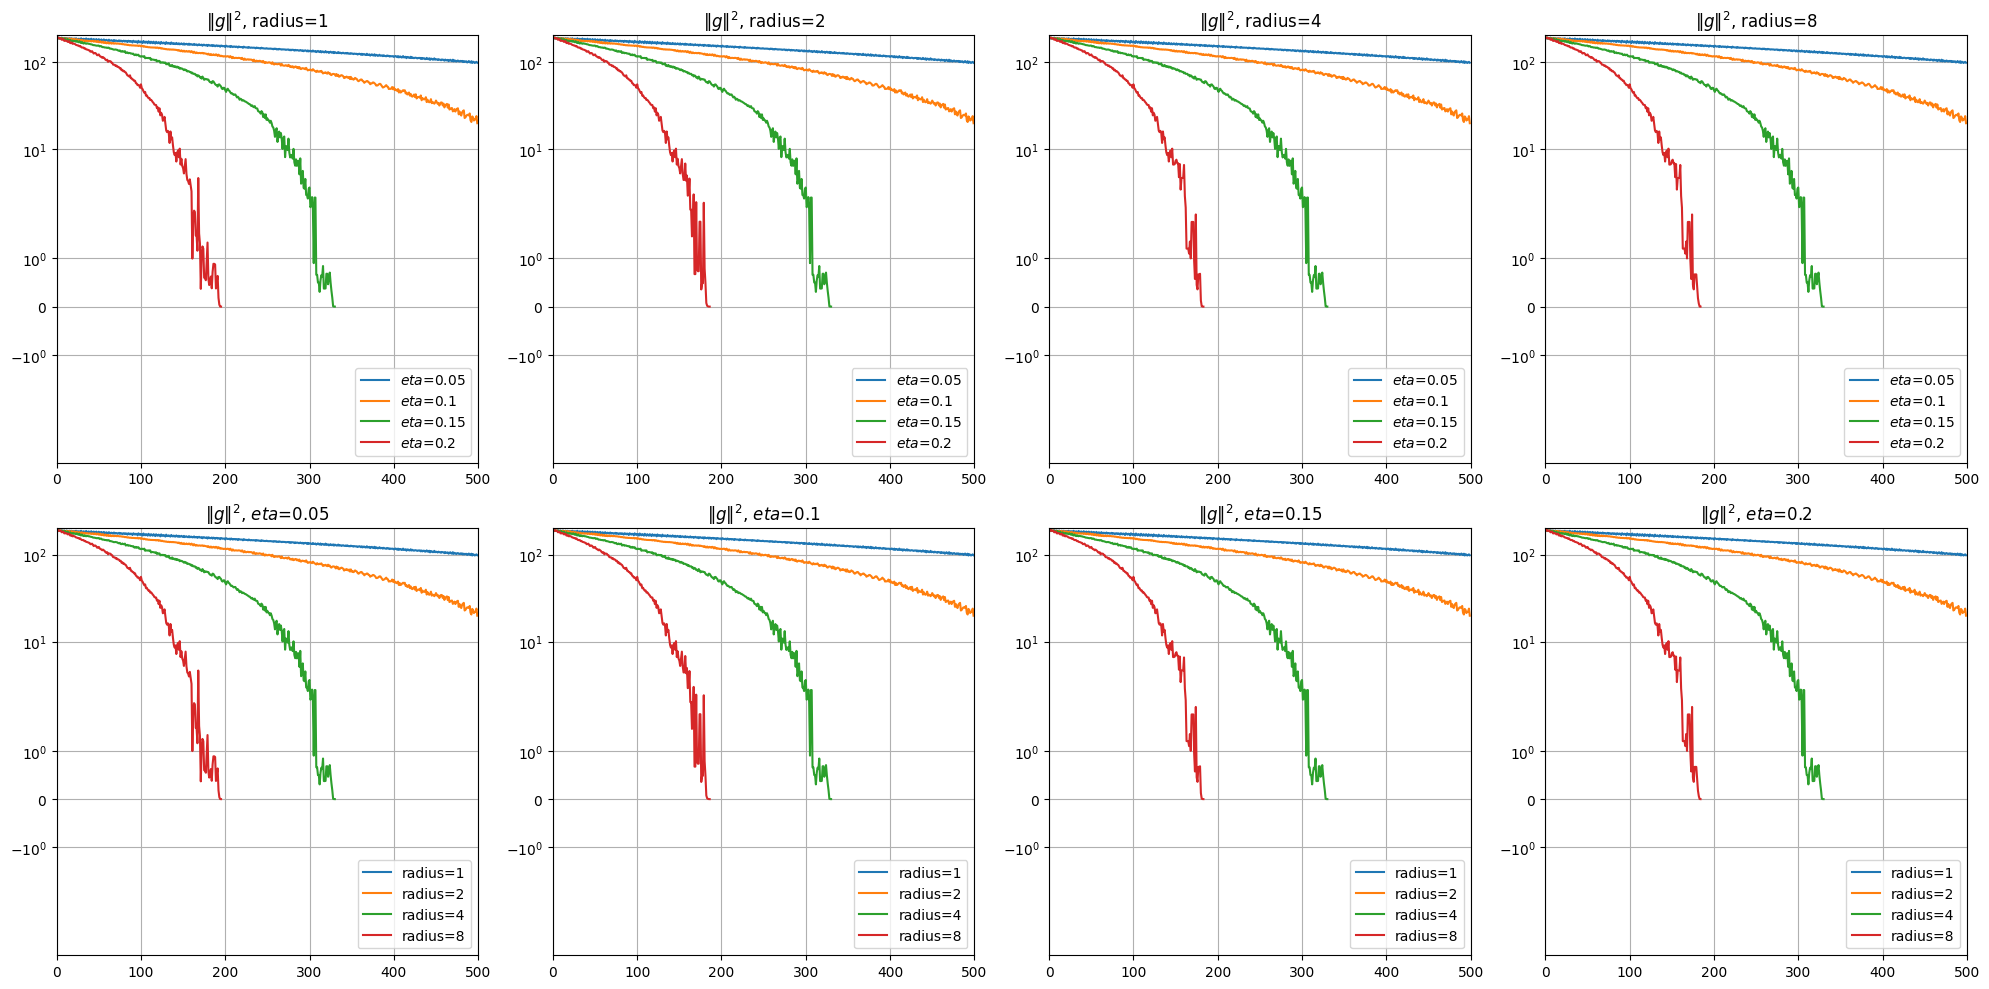

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Plot comparing sequence of g with 8 subplots
for i, radius in enumerate(max_r_ls):
    for j, eta in enumerate(eta_ls):
      axes[0, i].plot(g_array[i,j], label=f'$eta$={eta}')
    axes[0, i].grid(True)
    axes[0, i].set_title(f'$\|g\|^2$, radius={radius}')
    axes[0, i].set_xlim(0, 500)
    axes[0, i].set_yscale('symlog')
    axes[0, i].legend(loc='lower right')

for i, eta in enumerate(eta_ls):
    for j, radius in enumerate(max_r_ls):
        axes[1, i].plot(g_array[i,j], label=f'radius={radius}')
    axes[1, i].grid(True)
    axes[1, i].set_title(f'$\|g\|^2$, $eta$={eta}')
    axes[1, i].set_xlim(0, 500)
    axes[1, i].set_yscale('symlog')
    axes[1, i].legend(loc='lower right')

plt.tight_layout()
plt.show()

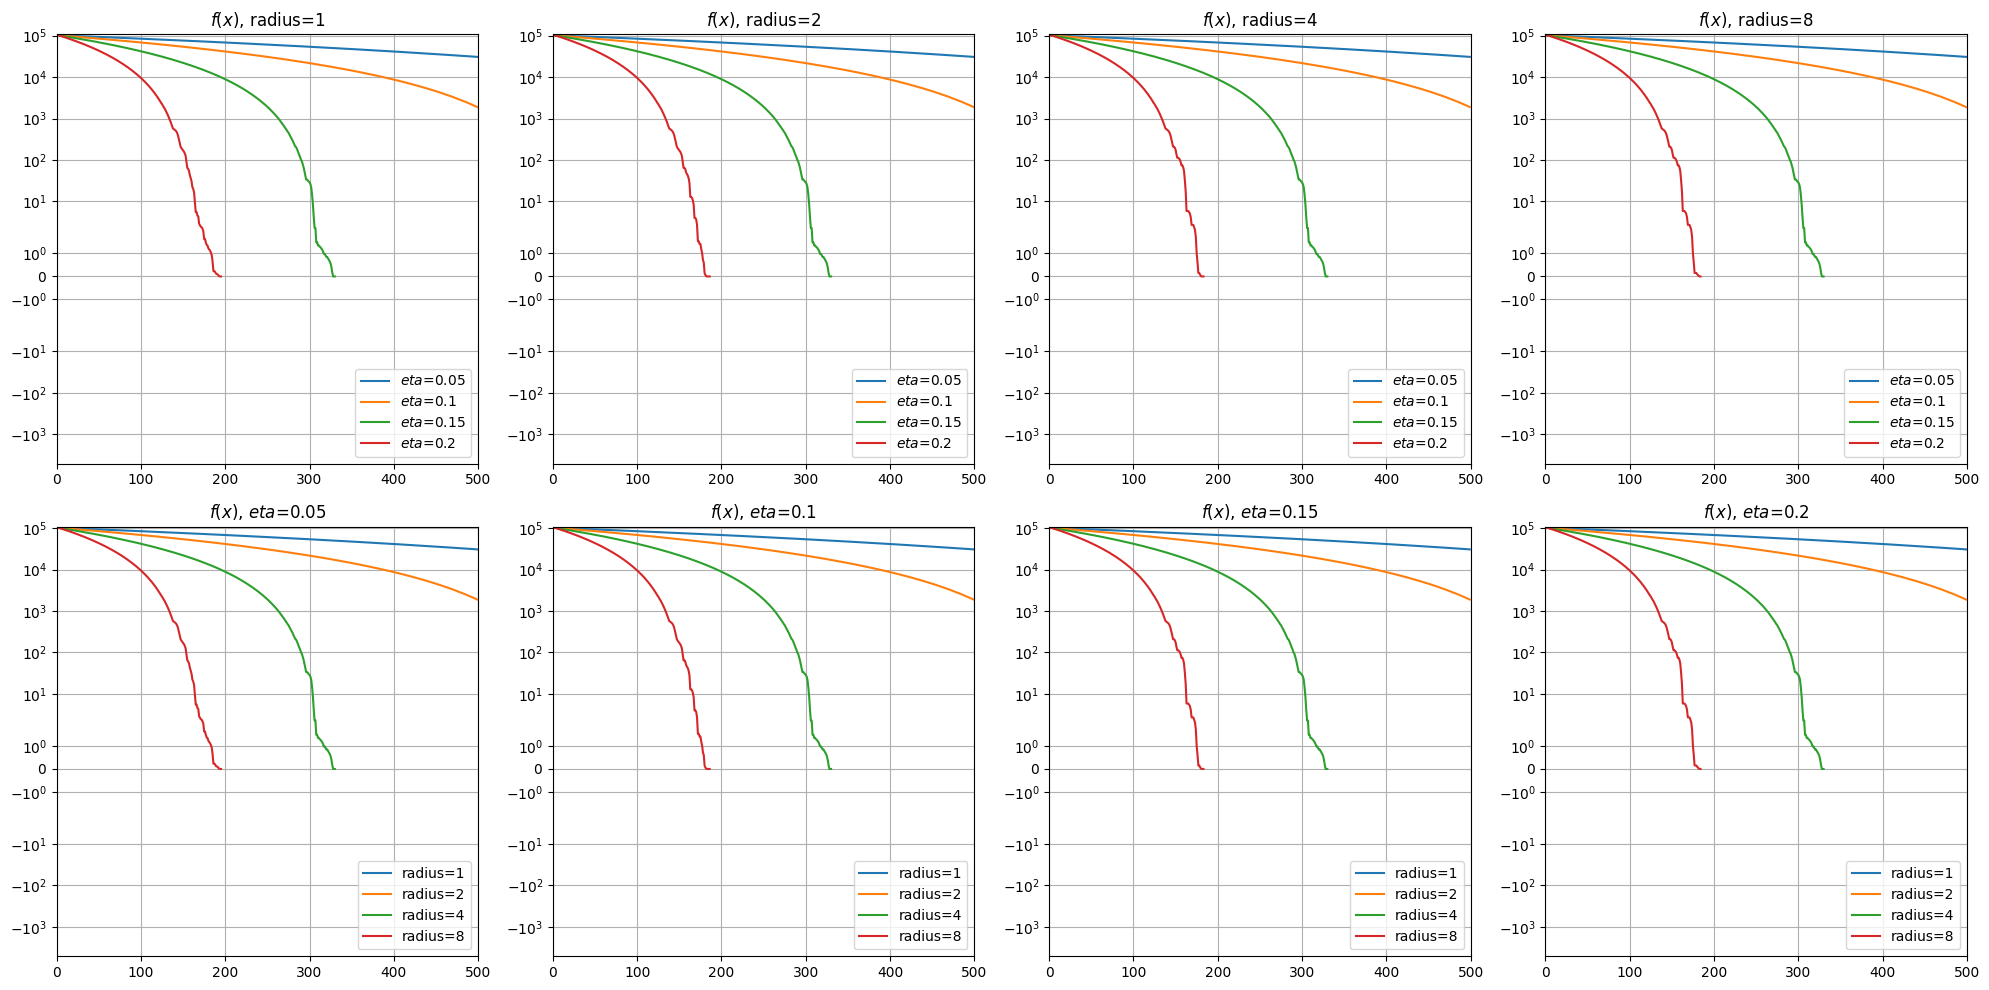

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Plot comparing sequence of g with 8 subplots
for i, radius in enumerate(max_r_ls):
    for j, eta in enumerate(eta_ls):
      axes[0, i].plot(f_array[i,j], label=f'$eta$={eta}')
    axes[0, i].grid(True)
    axes[0, i].set_title(f'$f(x)$, radius={radius}')
    axes[0, i].set_xlim(0, 500)
    axes[0, i].set_yscale('symlog')
    axes[0, i].legend(loc='lower right')

for i, eta in enumerate(eta_ls):
    for j, radius in enumerate(max_r_ls):
        axes[1, i].plot(f_array[i,j], label=f'radius={radius}')
    axes[1, i].grid(True)
    axes[1, i].set_title(f'$f(x)$, $eta$={eta}')
    axes[1, i].set_xlim(0, 500)
    axes[1, i].set_yscale('symlog')
    axes[1, i].legend(loc='lower right')

plt.tight_layout()
plt.show()